## Detection and Classification of Malicious URLS with Deep Learning

In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection
import matplotlib
from matplotlib import pylab as plt
#import gensim
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import merge
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate, merge, Conv1D
from keras.layers import TimeDistributed, Bidirectional
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import initializers
from keras import backend as K
tf.python.control_flow_ops = tf
from pathlib import Path
import json
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
from urllib.parse import urlparse

%matplotlib inline
cwd = os.getcwd()#To access the path of current working directory
path=cwd+"/"+"data"+"/"
data=pd.read_csv(path +"sample_10.csv")
data.head()
df=data
df.head()


,url,malicious
0,http://www.facebook-log1in.com/,1
1,http://getir.net/yg4t,1
2,http://crosscitydental.com/,0
3,http://www.tenttrails.com/jscripts/product.js,0
4,http://103.224.193.105/,0


### Preprocessing Raw URLs


In [3]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.url]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=100
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
print(X)
# Step 3: Extract labels form df to numpy array
target = np.array(df.malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

[[ 0  0  0 ..., 25 23 77]
 [ 0  0  0 ..., 17  5 30]
 [ 0  0  0 ..., 25 23 77]
 ..., 
 [ 0  0  0 ..., 25 23 77]
 [ 0  0  0 ..., 27 31 77]
 [ 0  0  0 ..., 25 30 83]]
Matrix dimensions of X:  (9998, 100) Vector dimension of target:  (9998,)


In [50]:
test_url = 'http://www.facebook-log1in.com/'
print([printable.index(x)+1 for x in test_url if x in printable])

[18, 30, 30, 26, 78, 77, 77, 33, 33, 33, 76, 16, 11, 13, 15, 12, 25, 25, 21, 75, 22, 25, 17, 2, 19, 24, 76, 13, 25, 23, 77]


In [4]:
# GENERAL get layer dimensions for any model!
def print_layers_dims(model):
    l_layers = model.layers
    # Note None is ALWAYS batch_size
    for i in range(len(l_layers)):
        print(l_layers[i])
        print('Input Shape: ', l_layers[i].input_shape, 'Output Shape: ', l_layers[i].output_shape)


### Training and Evaluation


In [5]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, test_size=0.25, random_state=33)

#### Simple LSTM
Model features
1. LSTM 
2. Activation function :Sigmoid. 
3. Loss Function binary_crossentropy
4. number of Epochs 5

In [6]:
## Simple LSTM
def simple_lstm(max_len=100, emb_dim=32, max_vocab_len=100, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

    
    # LSTM layer
    lstm = LSTM(lstm_output_size)(emb)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    
    sgd= SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Fit model and Cross-Validation, ARCHITECTURE 1 SIMPLE LSTM
nb_epoch = 5
batch_size = 32

model = simple_lstm()
model.fit(X_train, target_train, nb_epoch=nb_epoch, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
print_layers_dims(model)

Epoch 1/5
7498/7498 [==============================] - 48s 6ms/step - loss: 0.6168 - acc: 0.7386
Epoch 2/5
7498/7498 [==============================] - 50s 7ms/step - loss: 0.5284 - acc: 0.7559
Epoch 3/5
7498/7498 [==============================] - 49s 7ms/step - loss: 0.4860 - acc: 0.7682
Epoch 4/5
7498/7498 [==============================] - 48s 6ms/step - loss: 0.4548 - acc: 0.7891
Epoch 5/5
2500/2500 [==============================] - 3s 1ms/step

Final Cross-Validation Accuracy 0.826 

Input Shape:  (None, 100) Output Shape:  (None, 100)
Input Shape:  (None, 100) Output Shape:  (None, 100, 32)
Input Shape:  (None, 100, 32) Output Shape:  (None, 32)
Input Shape:  (None, 32) Output Shape:  (None, 32)
Input Shape:  (None, 32) Output Shape:  (None, 1)


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           3200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


### With inputs from Professor used a fully connected CNN 

In [12]:
def conv_fully(max_len=100, emb_dim=32, max_vocab_len=100, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    def sum_1d(X):
        return K.sum(X, axis=1)
    def get_conv_layer(emb, kernel_size=5, filters=256):
        # Conv layer
        conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                     border_mode='same')(emb)
        conv = ELU()(conv)

        conv = Lambda(sum_1d, output_shape=(filters,))(conv)
        #conv = BatchNormalization(mode=0)(conv)
        conv = Dropout(0.5)(conv)
        return conv
        
    # Multiple Conv Layers
    
    # calling custom conv function from above
    conv1 = get_conv_layer(emb, kernel_size=2, filters=256)
    conv2 = get_conv_layer(emb, kernel_size=3, filters=256)
    conv3 = get_conv_layer(emb, kernel_size=4, filters=256)
    conv4 = get_conv_layer(emb, kernel_size=5, filters=256)

    # Fully Connected Layers
    merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

    hidden1 = Dense(1024)(merged)
    hidden1 = ELU()(hidden1)
    hidden1 = BatchNormalization(mode=0)(hidden1)
    hidden1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(1024)(hidden1)
    hidden2 = ELU()(hidden2)
    hidden2 = BatchNormalization(mode=0)(hidden2)
    hidden2 = Dropout(0.5)(hidden2)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(hidden2)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Model Characteristics
1. 4 Fully connected layers. 
2. Activation function used is sigmoid. 
3. Optimizer in used is Adam
4. Loss function in use Binary Cross entropy. 
5. With  5 Epocs and a batch size of 100  is Final Cross-Validation Accuracy 0.8008

In [13]:
# Fit model and Cross-Validation, ARCHITECTURE 3 CONV + FULLY CONNECTED
epochs = 5
batch_size = 32

model = conv_fully()
model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')
print_layers_dims(model)

Epoch 1/5
7498/7498 [==============================] - 21s 3ms/step - loss: 0.8857 - acc: 0.5682
Epoch 2/5
7498/7498 [==============================] - 21s 3ms/step - loss: 0.7109 - acc: 0.6583
Epoch 3/5
7498/7498 [==============================] - 21s 3ms/step - loss: 0.6300 - acc: 0.7118
Epoch 4/5
7498/7498 [==============================] - 22s 3ms/step - loss: 0.6044 - acc: 0.7327
Epoch 5/5
2500/2500 [==============================] - 2s 780us/step

Final Cross-Validation Accuracy 0.806 

Input Shape:  (None, 100) Output Shape:  (None, 100)
Input Shape:  (None, 100) Output Shape:  (None, 100, 32)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 32)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 100, 256)
Input Shape:  (None,

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 32)      3200        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100, 32)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     16640       dropout_2[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [15]:
# GENERAL save model to disk function!
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    #have h5py installed
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    

In [16]:
model_name = "deeplearning_1DConv"
save_model(path + model_name + ".json", path + model_name + ".h5")
#model = load_model(path + model_name + ".json", path + model_name + ".h5")
print_layers_dims(model)

Input Shape:  (None, 100) Output Shape:  (None, 100)
Input Shape:  (None, 100) Output Shape:  (None, 100, 32)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 32)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 32) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 100, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 256)
Input Shape:  (None, 100, 256) Output Shape:  (None, 256)
Input Shape:  (None, 256) Output Shape:  (None, 256)
Input Shape:  (None, 256) Output Shape:  (No

### Model 3 Bidelirectional LSTM and RNN

In [17]:
from keras.layers import Layer,initializers,Flatten,RepeatVector,Permute
from keras.layers.merge import Multiply
    
def binarize(x, sz=71):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))


def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 71
filter_length = [5, 3, 3]
nb_filter = [128, 196, 256 ]
pool_length = 2

# sentence input
in_sentence = Input(shape=(max_len,), dtype='int64')
# char indices to one hot matrix, 1D sequence to 2D 
embedded = Lambda(binarize, output_shape=binarize_outshape)(in_sentence)
# embedded: encodes sentence
for i in range(len(nb_filter)):
    embedded = Conv1D(filters=nb_filter[i],
                      kernel_size=filter_length[i],
                      padding='valid',
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      strides=1)(embedded)
    embedded = Dropout(0.2)(embedded)
    embedded = MaxPooling1D(pool_size=pool_length)(embedded)
bi_lstm_sent = \
    Bidirectional(LSTM(100, return_sequences=True, dropout=0.15, recurrent_dropout=0.15, implementation=0))(embedded)


    
# compute importance for each step
attention = TimeDistributed(Dense(1, activation='tanh'))(bi_lstm_sent) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(200)(attention)
attention = Permute([2, 1])(attention)    
    

# apply the attention 
sent_representation = Multiply()([bi_lstm_sent, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)
    
    
# sent_encode = merge([forward_sent, backward_sent], mode='concat', concat_axis=-1)
sent_encode = Dropout(0.4)(sent_representation)
sent_encode = Activation("relu")(sent_encode)
sent_encode = Dense(units=2)(sent_encode)
sent_encode = Activation("softmax")(sent_encode)

# sentence encoder
model = Model(inputs=in_sentence, outputs=sent_encode)

model.summary()
#model = utils.make_parallel(model, 2)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 100, 71)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 128)      45568       lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 96, 128)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [18]:
adam = Adam()
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['sparse_categorical_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [20]:
hist=model.fit(X_train, target_train, epochs=5, batch_size=32)
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')


Epoch 1/5
7498/7498 [==============================] - 22s 3ms/step - loss: 0.4843 - acc: 0.7787
Epoch 2/5
7498/7498 [==============================] - 21s 3ms/step - loss: 0.4253 - acc: 0.8078
Epoch 3/5
7498/7498 [==============================] - 22s 3ms/step - loss: 0.3539 - acc: 0.8528
Epoch 4/5
7498/7498 [==============================] - 22s 3ms/step - loss: 0.2942 - acc: 0.8864
Epoch 5/5
2500/2500 [==============================] - 2s 863us/step

Final Cross-Validation Accuracy 0.8456 



### Results

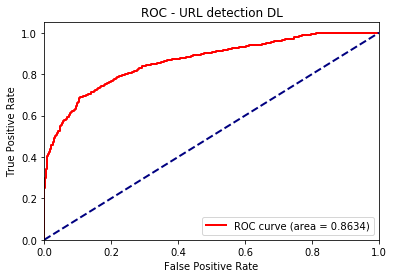

In [21]:
from sklearn import metrics
pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(target_test, pred[:,1], pos_label=1)
auc_m = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='red',lw=lw, label='ROC curve (area = %0.4f)' % auc_m)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - URL detection DL')
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
f1 = metrics.f1_score(target_test, pred[:,1]>0.5)
acc = metrics.accuracy_score(target_test, pred[:,1]>0.5)
print ("f1 = ", f1, "acc = ", acc, "auc=" , auc_m)
#print ("test confusion matrix\n" , confusion_matrix(target_test, pred[:,1]>0.5))

f1 =  0.659010600707 acc =  0.8456 auc= 0.863376439579


### Predicton

In [ ]:
X_predict_o = ['wikipedia.com',
             'google.com',
             'pakistanifacebookforever.com',
             'www.radsport-voggel.de',
             'ahrenhei.without-transfer.ru',
             'www.itidea.it',
             'stackoverflow.com',
             'dzone.com',
            'keras.io',
             'www.tiktik.co.il']

In [32]:
# Initial Data Preparation URL

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in X_predict_o]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=100
X1 = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
#print(X1)
# Step 3: Extract labels form df to numpy array
target = np.array(df.malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (1, 100) Vector dimension of target:  (9998,)


In [31]:
prd1 = model.predict(X1)
dfn = pd.DataFrame(columns=('site', 'score', 'prediction'))
pd.set_option('max_colwidth',500)    
for i in range(len(X_predict_o)):
    a = [X_predict_o[i],  prd1[i,1],prd1[i,1]>0.5 ]
    dfn.loc[i] = a
dfn


,site,score,prediction
0,wikipedia.com,0.007914,False
1,google.com,0.007872,False
2,pakistanifacebookforever.com,0.064834,False
3,www.radsport-voggel.de,0.008443,False
4,ahrenhei.without-transfer.ru,0.042111,False
5,www.itidea.it,0.008915,False
6,stackoverflow.com,0.009805,False
7,dzone.com,0.007869,False
8,keras.io,0.007861,False
9,www.tiktik.co.il,0.009828,False


The text in the document by Lakshmi Peri is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/